## A tutorial on the xmask package

### How to install

Get the latest version of xsuite, cpymad, etc:

    pip install xsuite
    pip install cpymad

Get hllhc15 
    
    git clone https://github.com/lhcopt/hllhc15.git

Uninstall the old version of xmask (not compatible with lhc errors as for now):

    pip uninstall xmask

Install the new version of xmask locally, including submodules for lhc errors:

    git clone https://github.com/xsuite/xmask.git xmask_github
    cd xmask_github
    git submodule init
    git submodule update
    pip install -e .

One can precompile the code in xsuite for faster execution:

    xsuite-compile


### Imports

In [1]:
# Standard imports
import os
import pandas as pd
import matplotlib.pyplot as plt

# Xmask
import xmask as xm
import xtrack as xt

# Cpymad (Python wrapper for MAD-X, used to build sequence and apply optics)
from cpymad.madx import Madx

# Import user-defined optics-specific tools (functions to build sequence and apply optics)
from tools import optics_specific_tools_hlhc15 as ost

# Plotting function
from tools.plotting_functions import plot_all

# Plotly renderer
import plotly.io as pio

# ! Renderer should be set to 'notebook' or 'vscode' (depending on the IDE used) for interactive plots
pio.renderers.default = "svg"


In [2]:
# Constants to compartimentalize the code
DO_STEP_0 = False
DO_EXPLORATION_STEP_0 = True
DO_STEP_1 = False
DO_EXPLORATION_STEP_1 = True
DO_STEP_2 = False
DO_EXPLORATION_STEP_2 = True
DO_STEP_3 = False
DO_EXPLORATION_STEP_3 = True
DO_STEP_4 = True


### Build collider from MAD model

In [3]:
config_mad_model = None
if DO_STEP_0:
    # Get mad config from general config file
    with open("config.yaml", "r") as fid:
        config = xm.yaml.load(fid)
    config_mad_model = config["config_mad"]

config_mad_model


In [4]:
if DO_STEP_0:
    # Make mad environment
    xm.make_mad_environment(links=config_mad_model["links"])

    # Start mad
    mad_b1b2 = Madx(command_log="mad_collider.log")
    mad_b4 = Madx(command_log="mad_b4.log")


In [5]:
if DO_STEP_0:
    # Build sequences for beam 1 and 4
    ost.build_sequence(mad_b1b2, mylhcbeam=1)
    ost.build_sequence(mad_b4, mylhcbeam=4)


In [6]:
if DO_STEP_0:
    # Apply optics (only for b1b2, b4 will be generated from b1b2)
    ost.apply_optics(mad_b1b2, optics_file=config_mad_model["optics_file"])


In [7]:
if DO_STEP_0:
    # Build xsuite collider
    collider = xm.lhc.build_xsuite_collider(
        sequence_b1=mad_b1b2.sequence.lhcb1,
        sequence_b2=mad_b1b2.sequence.lhcb2,
        sequence_b4=mad_b4.sequence.lhcb2,
        beam_config=config_mad_model["beam_config"],
        enable_imperfections=config_mad_model["enable_imperfections"],
        enable_knob_synthesis=config_mad_model["enable_knob_synthesis"],
        pars_for_imperfections=config_mad_model["pars_for_imperfections"],
        ver_lhc_run=config_mad_model["ver_lhc_run"],
        ver_hllhc_optics=config_mad_model["ver_hllhc_optics"],
    )


In [8]:
if DO_STEP_0:
    # Create output folder if it does not exist
    if not os.path.exists("output"):
        os.makedirs("output")

    # Save to file
    collider.to_json("output/collider_00_from_mad.json")


In [9]:
if DO_STEP_0:
    # Remove all the temporaty files created in the process of building collider
    os.remove("mad_collider.log")
    os.remove("mad_b4.log")
    os.rmdir("temp")
    os.unlink("errors")
    os.unlink("acc-models-lhc")


### Explore vanilla collider with no knobs nor bb

In [10]:
if DO_EXPLORATION_STEP_0:
    # Collider can by reloaded from json file
    collider = xt.Multiline.from_json("output/collider_00_from_mad.json")

    # Build trackers to be able to twiss, track, etc
    collider.build_trackers()


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [11]:
if DO_EXPLORATION_STEP_0:
    # A collider contain a list of lines: beam 1 and beam 2, and beam 1 and beam 2 for the closed orbit (all knobs set to zero)
    print(collider.lines.keys())


dict_keys(['lhcb1', 'lhcb2', 'lhcb1_co_ref', 'lhcb2_co_ref'])


In [12]:
if DO_EXPLORATION_STEP_0:

    # A collider also contain some knobs
    print(list(collider.vars._get_value().items())[:10])

    # And same for the line inside of the collider
    print(list(collider.lhcb1.vars._get_value().items())[:10])


[('l.mqtli', 1.3), ('l.bptx', 0.0), ('imax_mctxf', 85.0), ('acbch6.l1b1', 0.0), ('bety_ip1', 0.3), ('acbv14.l1b2', 0.0), ('muxip1b1', 2.6427), ('l.tclim', 0.5), ('acbv33.l6b2', 0.0), ('lhclength', 26658.8832)]
[('l.mqtli', 1.3), ('l.bptx', 0.0), ('imax_mctxf', 85.0), ('acbch6.l1b1', 0.0), ('bety_ip1', 0.3), ('acbv14.l1b2', 0.0), ('muxip1b1', 2.6427), ('l.tclim', 0.5), ('acbv33.l6b2', 0.0), ('lhclength', 26658.8832)]


In [13]:
if DO_EXPLORATION_STEP_0:
    # Knobs values can be accessed and modified indivually
    print("Value before modification: ", collider.vars["on_x5"]._get_value())
    collider.vars["on_x5"] = 100
    print("Value after modification: ", collider.vars["on_x5"]._get_value())
    collider.vars["on_x5"] = 0


Value before modification:  0.0
Value after modification:  100


In [14]:
tw1 = None
if DO_EXPLORATION_STEP_0:
    # One can twiss the lines in the collider (in 4D, since RF hasn't been added yet)
    # Note that the twiss in the second line is reversed, to get the same s coordinates for both lines
    tw1_step0 = collider.lhcb1.twiss(method="4d")
    tw2_step0 = collider.lhcb2.twiss(method="4d").reverse()
    tw1_co_step0 = collider.lhcb1_co_ref.twiss(method="4d")
    tw2_co_step0 = collider.lhcb2_co_ref.twiss(method="4d").reverse()
    print(tw1_step0.to_pandas())


               name           s    x   px    y   py  zeta  delta  ptau  \
0               ip3      0.0000  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
1           drift_0      0.0000  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
2      mcbwv.4r3.b1     21.0300  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
3           drift_1     21.0300  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
4       bpmw.4r3.b1     22.5205  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
...             ...         ...  ...  ...  ...  ...   ...    ...   ...   
23680   drift_11768  26636.4387  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
23681  mcbwh.4l3.b1  26640.1832  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
23682   drift_11769  26640.1832  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
23683   lhcb1ip3_p_  26658.8832  0.0  0.0  0.0  0.0   0.0    0.0   0.0   
23684    _end_point  26658.8832  0.0  0.0  0.0  0.0   0.0    0.0   0.0   

             betx  ...        muy  muzeta       nux  nuy  nuzeta  \
0      121.566834  ...   0.000000     0.0  

In [15]:
if DO_EXPLORATION_STEP_0:
    # TwissTable offers fancy possibilites for indexing
    print(
        tw1_step0.rows[
            "ip4":"ip6",
            "mq.*",
            3500:3600:"s",
            tw1_step0.betx > 500,
            ["mqy.6r4.b1..1", "mqy.6r4.b1..2"],
        ].cols["s", "betx"]
    )


TwissTable: 2 rows, 19 cols
name                       s    betx
mqy.6r4.b1..1        3500.54 731.475
mqy.6r4.b1..2        3501.45 741.942


In [16]:
if DO_EXPLORATION_STEP_0:
    # We can check what the no beambeam elements have been added, e.g. in ip5
    tw1_step0 = collider.lhcb1.twiss(method="4d")
    print(tw1_step0.rows["ip4":"ip6", "bb.*"].cols["s"])


TwissTable: 2 rows, 18 cols
name                       s
bblr.4l5.b1           6471.7
bblr.4r5.b1          6852.64


In [17]:
if DO_EXPLORATION_STEP_0:
    # Check that for now the twiss is the same for the standard line and the reference line (since knobs haven't been applied)
    tw1_step0_pd = tw1_step0.to_pandas().drop(columns=["W_matrix"])
    tw1_co_step0_pd = tw1_co_step0.to_pandas().drop(columns=["W_matrix"])
    df_diff = pd.concat([tw1_step0_pd, tw1_co_step0_pd]).drop_duplicates(keep=False)
    print(df_diff)


Empty DataFrame
Columns: [name, s, x, px, y, py, zeta, delta, ptau, betx, bety, alfx, alfy, gamx, gamy, dx, dpx, dy, dzeta, dpy, mux, muy, muzeta, nux, nuy, nuzeta, betx1, bety1, betx2, bety2]
Index: []

[0 rows x 30 columns]


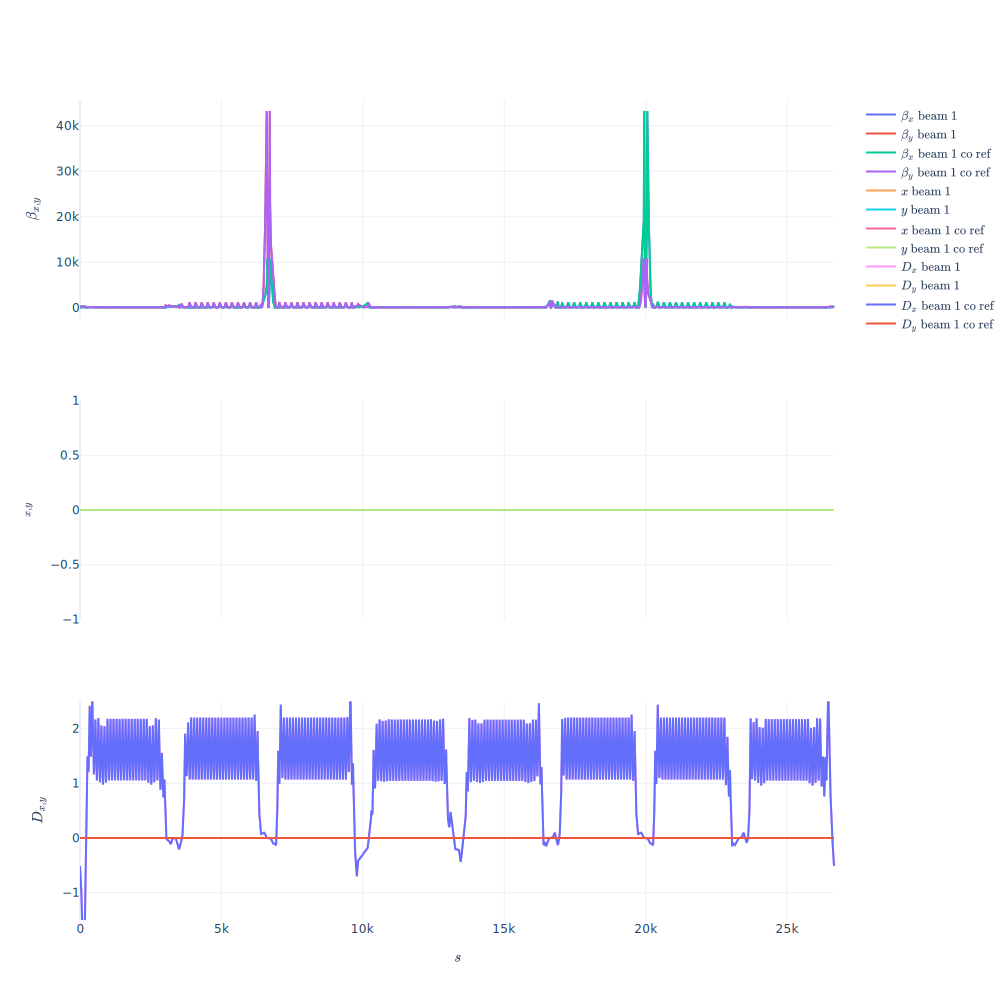

In [18]:
p = None
if DO_EXPLORATION_STEP_0:
    # For now, the beams are equal to their reference (since knobs haven't been applied)
    p = plot_all(tw1_step0_pd, tw1_co_step0_pd, "beam 1", "beam 1 co ref")
p


In [19]:
if DO_EXPLORATION_STEP_0:
    # One can also get the corresponding surveys
    sv1_step0 = collider.lhcb1.survey()
    sv2_step0 = collider.lhcb2.survey().reverse()
    sv1_co_step0 = collider.lhcb1_co_ref.survey()
    sv2_co_step0 = collider.lhcb2_co_ref.survey().reverse()

    print(sv1_step0.to_pandas())


             X    Y          Z     theta  phi  psi          name           s  \
0      0.00000  0.0   0.000000  0.000000  0.0  0.0           ip3      0.0000   
1      0.00000  0.0   0.000000  0.000000  0.0  0.0       drift_0      0.0000   
2      0.00000  0.0  21.030000  0.000000  0.0  0.0  mcbwv.4r3.b1     21.0300   
3      0.00000  0.0  21.030000  0.000000  0.0  0.0       drift_1     21.0300   
4      0.00000  0.0  22.520500  0.000000  0.0  0.0   bpmw.4r3.b1     22.5205   
...        ...  ...        ...       ...  ...  ...           ...         ...   
23680 -0.00008  0.0 -22.444629 -6.283185  0.0  0.0   drift_11768  26636.4387   
23681 -0.00008  0.0 -18.700129 -6.283185  0.0  0.0  mcbwh.4l3.b1  26640.1832   
23682 -0.00008  0.0 -18.700129 -6.283185  0.0  0.0   drift_11769  26640.1832   
23683 -0.00008  0.0  -0.000129 -6.283185  0.0  0.0   lhcb1ip3_p_  26658.8832   
23684 -0.00008  0.0  -0.000129 -6.283185  0.0  0.0    _end_point  26658.8832   

       drift_length  angle  tilt  
0   

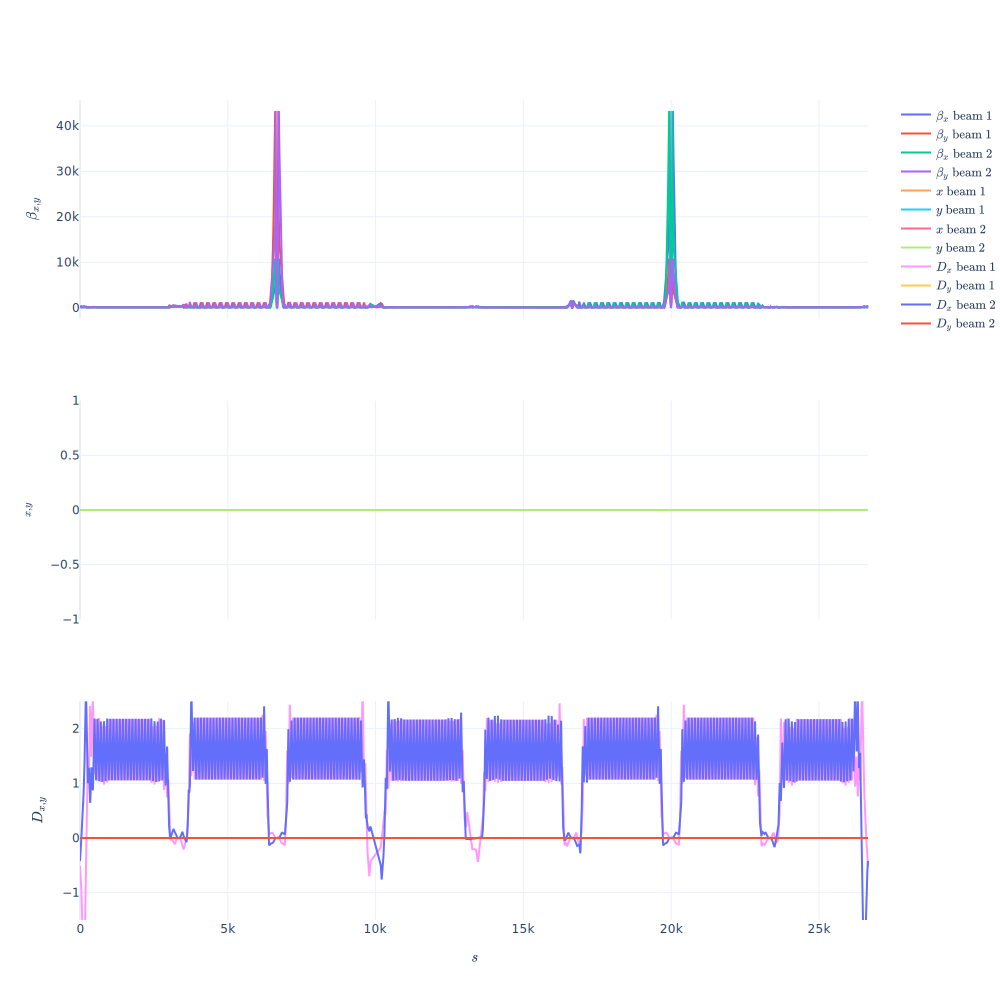

In [20]:
p = None
if DO_EXPLORATION_STEP_0:
    # We can check what the beams looks like along the collider
    tw1_step0_pd = tw1_step0.to_pandas()
    tw2_step0_pd = tw2_step0.to_pandas()
    p = plot_all(tw1_step0_pd, tw2_step0_pd, "beam 1", "beam 2")
p


### Set up beambeam lenses (they stay inactive and not configured) 

In [21]:
config_bb = None
if DO_STEP_1:
    # Collider can by reloaded from json file
    collider = xt.Multiline.from_json("output/collider_00_from_mad.json")

    # Get beambeam config from general config file
    with open("config.yaml", "r") as fid:
        config = xm.yaml.load(fid)
    config_bb = config["config_beambeam"]

config_bb


In [22]:
if DO_STEP_1:
    # Install beam-beam lenses (inactive and not configured)
    collider.install_beambeam_interactions(
        clockwise_line="lhcb1",
        anticlockwise_line="lhcb2",
        ip_names=["ip1", "ip2", "ip5", "ip8"],
        num_long_range_encounters_per_side=config_bb["num_long_range_encounters_per_side"],
        num_slices_head_on=config_bb["num_slices_head_on"],
        harmonic_number=35640,
        bunch_spacing_buckets=config_bb["bunch_spacing_buckets"],
        sigmaz=config_bb["sigma_z"],
    )


In [23]:
if DO_STEP_1:
    # Save collider as json
    collider.to_json("output/collider_01_bb_off.json")


### Explore the collider after setting up the beambeam lenses

In [24]:
if DO_EXPLORATION_STEP_1:
    # Collider can by reloaded from json file
    collider = xt.Multiline.from_json("output/collider_01_bb_off.json")

    # Build trackers to be able to twiss, track, etc
    collider.build_trackers()


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [25]:
if DO_EXPLORATION_STEP_1:
    # We can check what the beams elements have been added
    tw1_step1 = collider.lhcb1.twiss(method="4d")
    print(tw1_step1.rows["ip4":"ip5", "bb.*"].cols["s"])


TwissTable: 32 rows, 18 cols
name                                                 s
bblr.4l5.b1                                     6471.7
bb_lr.l5b1_25                                  6571.07
bb_lr.l5b1_24                                  6574.81
bb_lr.l5b1_23                                  6578.55
bb_lr.l5b1_22                                  6582.29
bb_lr.l5b1_21                                  6586.03
bb_lr.l5b1_20                                  6589.77
bb_lr.l5b1_19                                  6593.51
bb_lr.l5b1_18                                  6597.25
bb_lr.l5b1_17                                  6600.99
bb_lr.l5b1_16                                  6604.73
bb_lr.l5b1_15                                  6608.47
bb_lr.l5b1_14                                  6612.21
bb_lr.l5b1_13                                  6615.95
bb_lr.l5b1_12                                  6619.69
bb_lr.l5b1_11                                  6623.43
bb_lr.l5b1_10                       

In [26]:
if DO_EXPLORATION_STEP_1:
    # The beam is not anymore equal to its reference, as the reference has no beam-beam elements, which introduce many drifts
    tw1_step1_pd = tw1_step1.to_pandas().drop(columns=["W_matrix"]).round(4)
    tw1_co_step1 = collider.lhcb1_co_ref.twiss(method="4d")
    tw1_co_step1_pd = tw1_co_step1.to_pandas().drop(columns=["W_matrix"]).round(4)
    df_diff = pd.concat([tw1_step1_pd, tw1_co_step1_pd]).drop_duplicates(keep=False)
    print(df_diff)


                         name           s    x   px    y   py  zeta  delta  \
5437         drift_2716_part0   6555.9808  0.0  0.0  0.0  0.0   0.0    0.0   
5438            bb_lr.l5b1_25   6571.0679  0.0  0.0  0.0  0.0   0.0    0.0   
5439         drift_2716_part1   6571.0679  0.0  0.0  0.0  0.0   0.0    0.0   
5441   drift_2717_part0_part0   6573.3129  0.0  0.0  0.0  0.0   0.0    0.0   
5442            bb_lr.l5b1_24   6574.8079  0.0  0.0  0.0  0.0   0.0    0.0   
...                       ...         ...  ...  ...  ...  ...   ...    ...   
20920             drift_10388  23385.9270  0.0  0.0  0.0  0.0   0.0    0.0   
20924             drift_10390  23389.7070  0.0  0.0  0.0  0.0   0.0    0.0   
20928             drift_10392  23393.4870  0.0  0.0  0.0  0.0   0.0    0.0   
20930             drift_10393  23396.0395  0.0  0.0  0.0  0.0   0.0    0.0   
20932             drift_10394  23398.1470  0.0  0.0  0.0  0.0   0.0    0.0   

       ptau       betx  ...      mux      muy  muzeta  nux  nuy

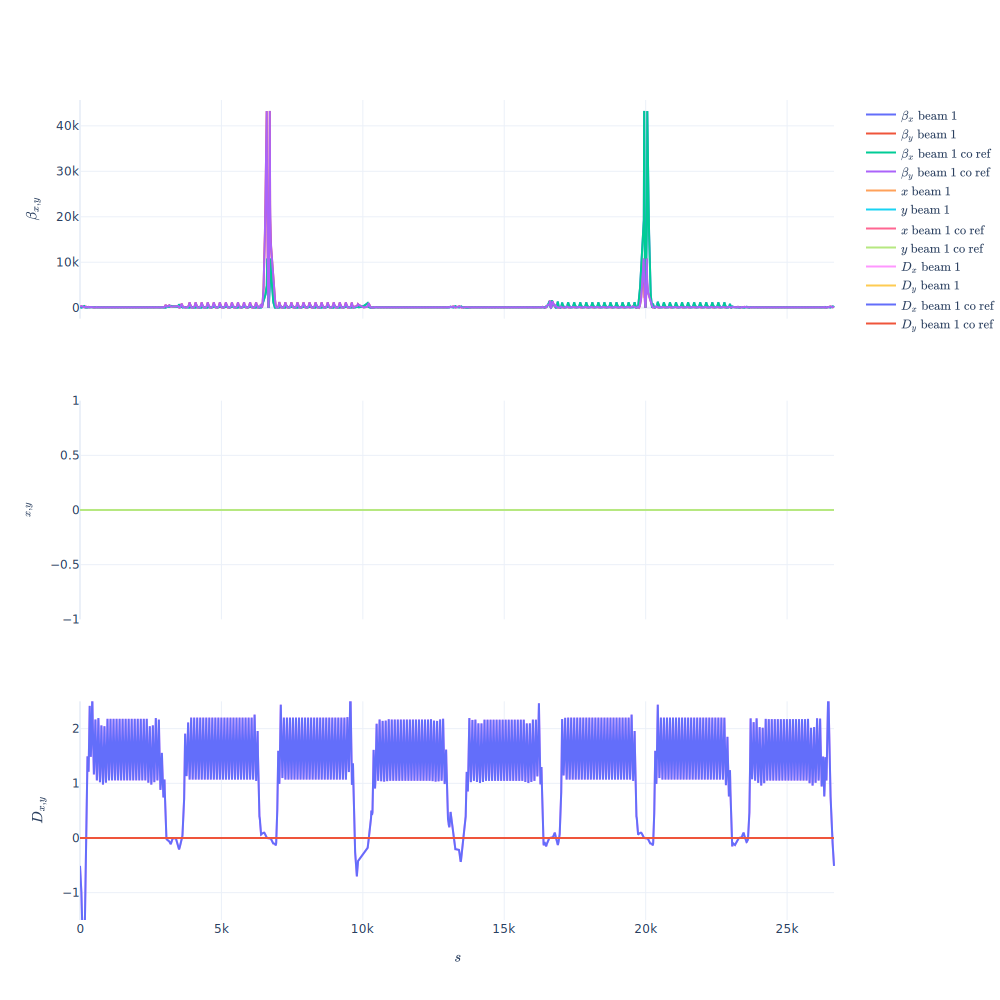

In [27]:
p = None
if DO_EXPLORATION_STEP_1:
    # However, the observables are still identical
    p = plot_all(tw1_step1_pd, tw1_co_step1_pd, "beam 1", "beam 1 co ref")
p


### Configure knobs and tuning

In [28]:
config_knobs_and_tuning = None
if DO_STEP_2:
    # Collider can by reloaded from json file
    collider = xt.Multiline.from_json("output/collider_01_bb_off.json")
    collider.build_trackers()

    # Get beambeam config from general config file
    with open("config.yaml", "r") as fid:
        config = xm.yaml.load(fid)
    config_knobs_and_tuning = config["config_knobs_and_tuning"]

config_knobs_and_tuning


In [29]:
if DO_STEP_2:
    # Set all knobs (crossing angles, dispersion correction, rf, crab cavities,
    # experimental magnets, etc.)
    for kk, vv in config_knobs_and_tuning["knob_settings"].items():
        collider.vars[kk] = vv


In [30]:
if DO_STEP_2:
    # Run the script to generate configuration for orbit correction
    %run 'tools/gen_config_orbit_correction.py'

    # Adjust tune and chromaticity
    for line_name in ['lhcb1', 'lhcb2']:

        knob_names = config_knobs_and_tuning['knob_names'][line_name]

        targets = {
            'qx': config_knobs_and_tuning['qx'][line_name],
            'qy': config_knobs_and_tuning['qy'][line_name],
            'dqx': config_knobs_and_tuning['dqx'][line_name],
            'dqy': config_knobs_and_tuning['dqy'][line_name],
        }

        xm.machine_tuning(line=collider[line_name],
            enable_closed_orbit_correction=True,
            enable_linear_coupling_correction=True,
            enable_tune_correction=True,
            enable_chromaticity_correction=True,
            knob_names=knob_names,
            targets=targets,
            line_co_ref=collider[line_name+'_co_ref'],
            co_corr_config=config_knobs_and_tuning['closed_orbit_correction'][line_name])
        
    # Remove temporary files
    os.remove('corr_co_lhcb1.json')
    os.remove('corr_co_lhcb2.json')

In [31]:
if DO_STEP_2:
    # Save collider as json
    collider.to_json("output/collider_02_tuned_bb_off.json")


### Explore the collider with the new tune

In [32]:
if DO_EXPLORATION_STEP_2:
    # Collider can by reloaded from json file
    collider = xt.Multiline.from_json("output/collider_02_tuned_bb_off.json")

    # Build trackers to be able to twiss, track, etc
    collider.build_trackers()


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [33]:
if DO_EXPLORATION_STEP_2:
    # Compute new twiss
    tw1_step2 = collider.lhcb1.twiss(method="4d")
    tw2_step2 = collider.lhcb2.twiss(method="4d").reverse()
    tw1_co_step2 = collider.lhcb1_co_ref.twiss(method="4d")
    tw2_co_step2 = collider.lhcb2_co_ref.twiss(method="4d").reverse()


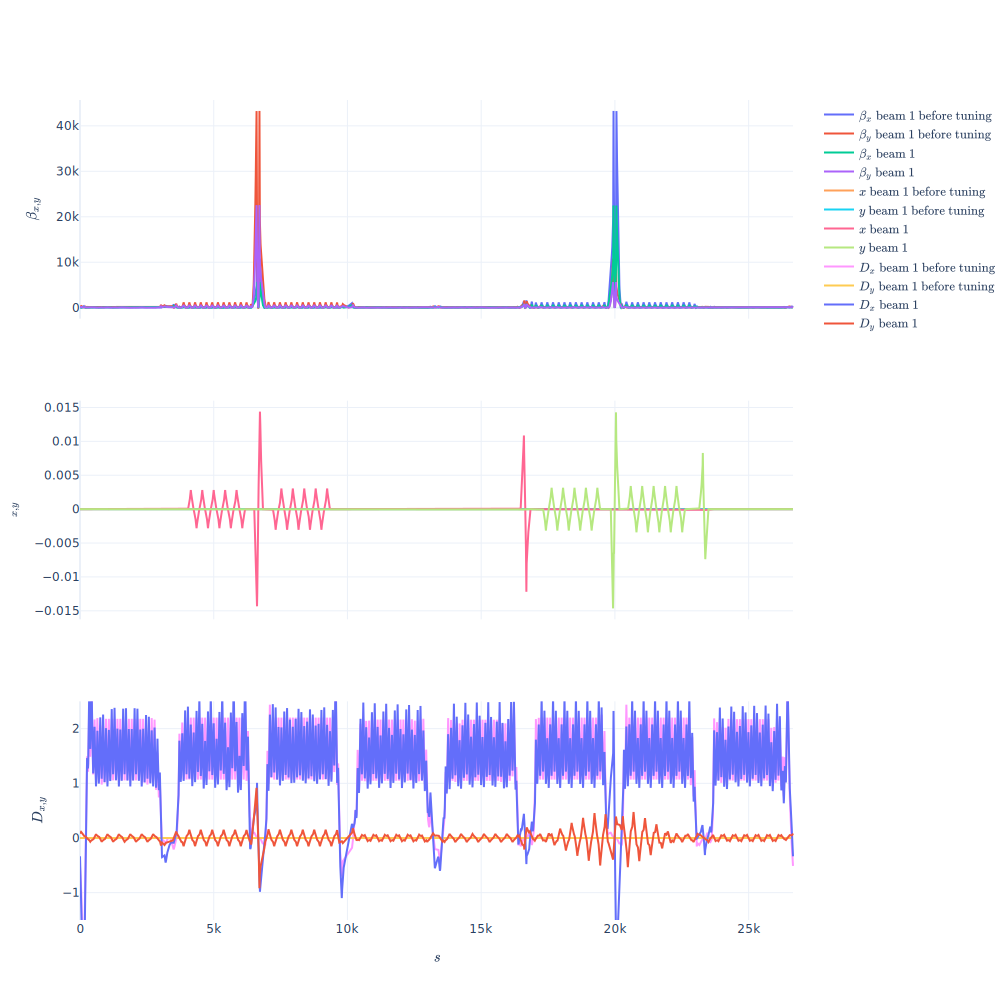

In [34]:
p = None

if DO_EXPLORATION_STEP_2:
    # Check how the crossing angle has changed
    tw1_step2_pd = tw1_step2.to_pandas()
    tw1_co_step2_pd = tw1_co_step2.to_pandas()

    p = plot_all(tw1_step1_pd, tw1_step2_pd, "beam 1 before tuning ", "beam 1")

p


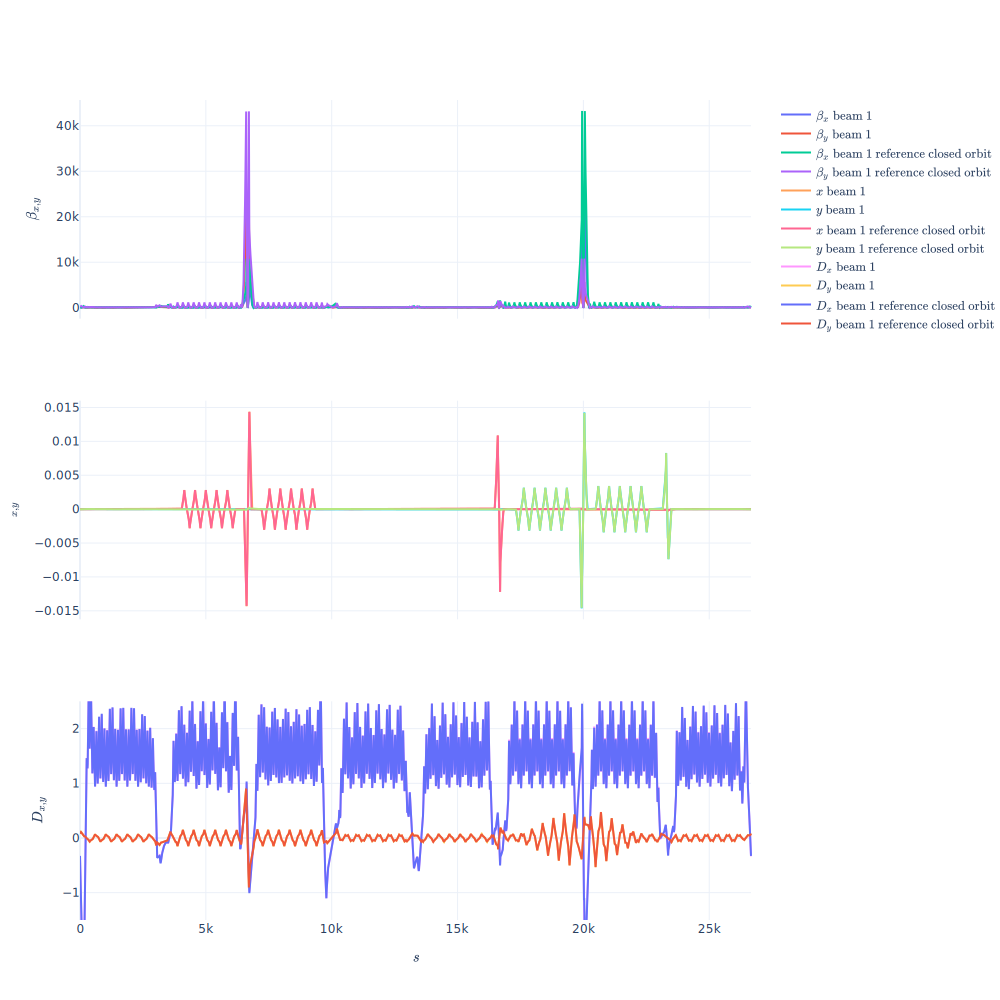

In [35]:
p = None



if DO_EXPLORATION_STEP_2:
    # Check how the crossing angle has changed
    tw1_step2_pd = tw1_step2.to_pandas()
    tw1_co_step2_pd = tw1_co_step2.to_pandas()

    p = plot_all(tw1_step2_pd, tw1_co_step2_pd, "beam 1", "beam 1 reference closed orbit")
p


### Set beambeam interactions

In [36]:
config_bb = None
if DO_STEP_3:
    # Collider can by reloaded from json file
    collider = xt.Multiline.from_json("output/collider_02_tuned_bb_off.json")
    collider.build_trackers()

    # Get beambeam config from general config file
    with open("config.yaml", "r") as fid:
        config = xm.yaml.load(fid)
    config_bb = config["config_beambeam"]

config_bb


In [37]:
if DO_STEP_3:
    # Configure beam-beam lenses
    collider.configure_beambeam_interactions(
        num_particles=config_bb["num_particles_per_bunch"],
        nemitt_x=config_bb["nemitt_x"],
        nemitt_y=config_bb["nemitt_y"],
    )


In [38]:
if DO_STEP_3:
    # Save collider as json
    collider.to_json("output/collider_03_tuned_bb_on.json")


### Explore final state of the collider

In [39]:
if DO_EXPLORATION_STEP_3:
    # Collider can by reloaded from json file
    collider = xt.Multiline.from_json("output/collider_03_tuned_bb_on.json")

    # Build trackers to be able to twiss, track, etc
    collider.build_trackers()


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [40]:
if DO_EXPLORATION_STEP_3:
    # Compute new twiss
    tw1_step3 = collider.lhcb1.twiss(method="4d")
    tw2_step3 = collider.lhcb2.twiss(method="4d").reverse()
    tw1_co_step3 = collider.lhcb1_co_ref.twiss(method="4d")
    tw2_co_step3 = collider.lhcb2_co_ref.twiss(method="4d").reverse()


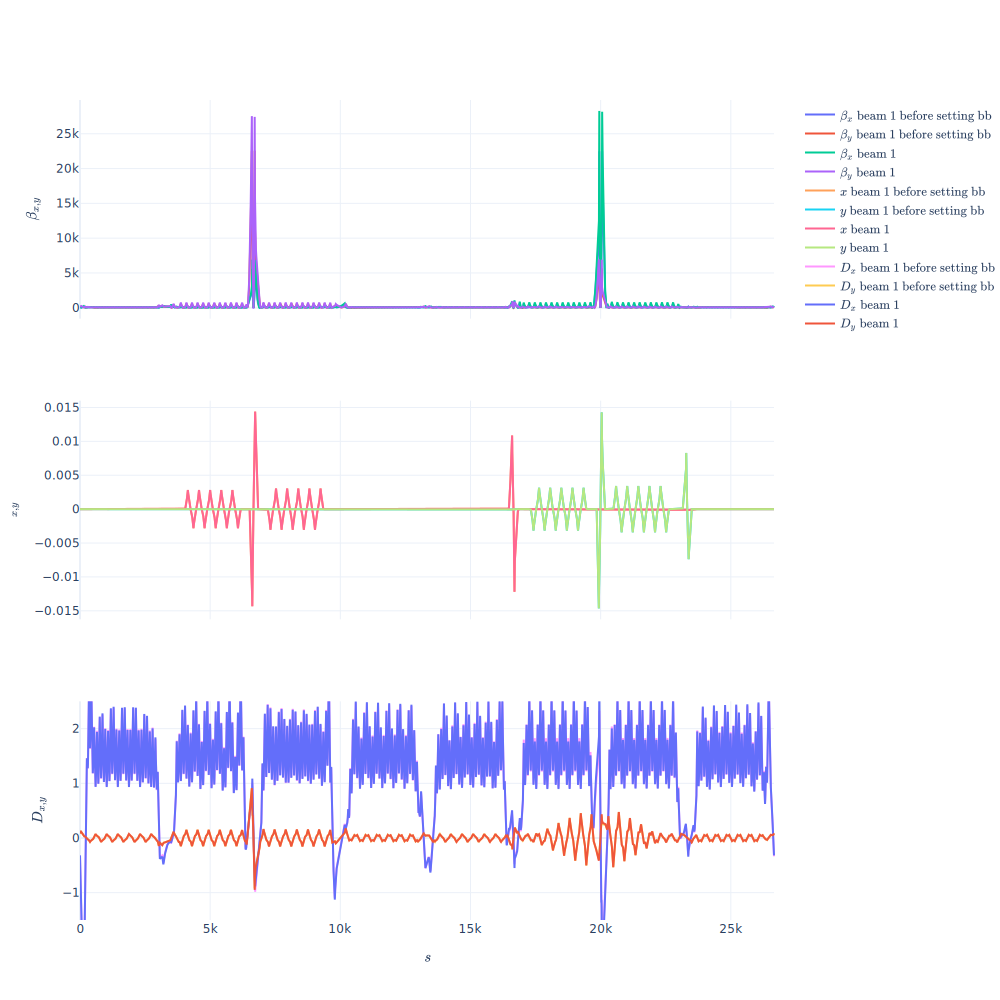

In [41]:
p = None
if DO_EXPLORATION_STEP_3:
    # Check how the crossing angle has changed
    tw1_step3_pd = tw1_step3.to_pandas()
    tw1_co_step3_pd = tw1_co_step3.to_pandas()

    p = plot_all(tw1_step2_pd, tw1_step3_pd, "beam 1 before setting bb ", "beam 1")

p


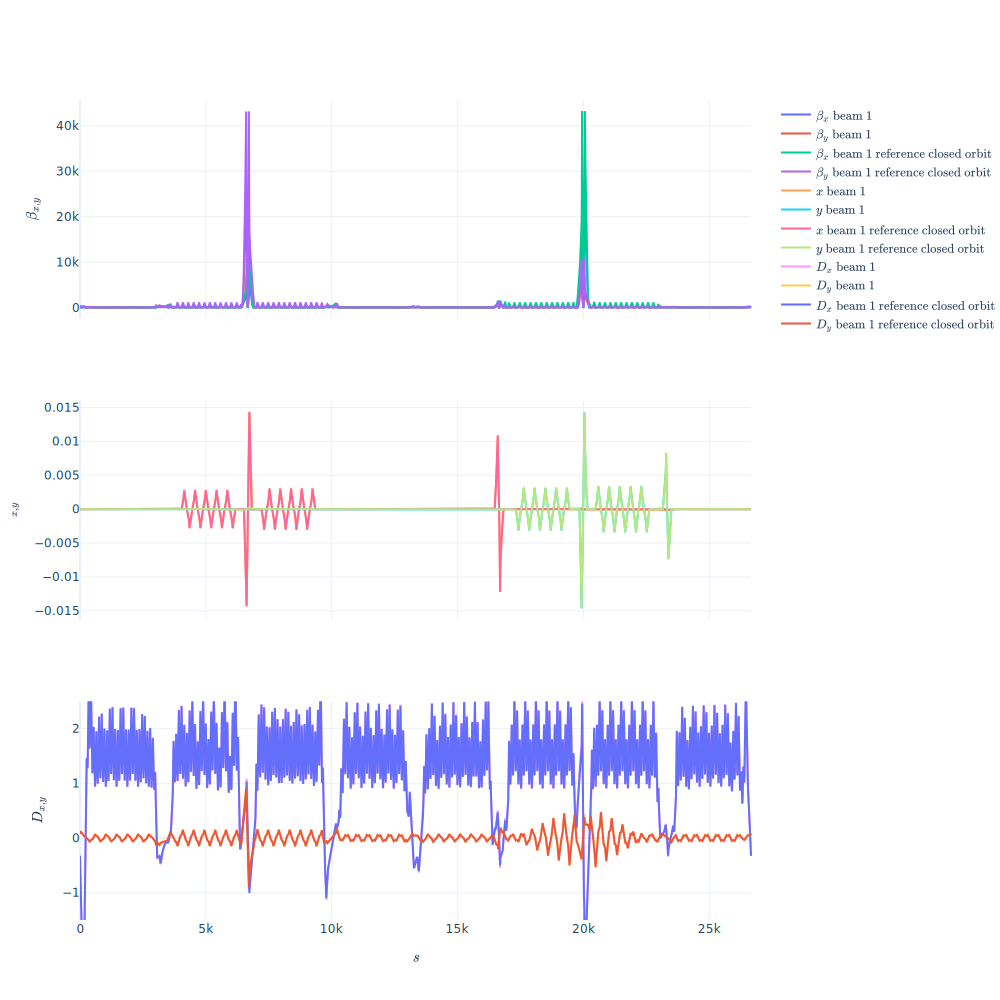

In [42]:
p = None
if DO_EXPLORATION_STEP_3:
    p = plot_all(tw1_step3_pd, tw1_co_step3_pd, "beam 1", "beam 1 reference closed orbit")
p


### Compute tune footprint

In [43]:
if DO_STEP_4:
    # Collider can by reloaded from json file
    collider = xt.Multiline.from_json("output/collider_03_tuned_bb_on.json")

    # Build trackers to be able to twiss, track, etc
    collider.build_trackers()


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


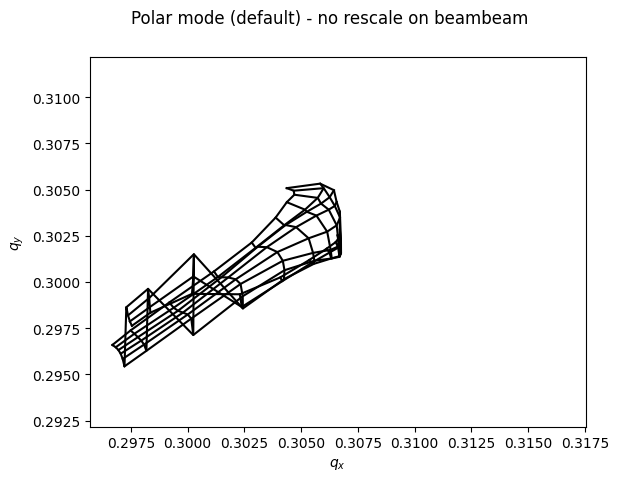

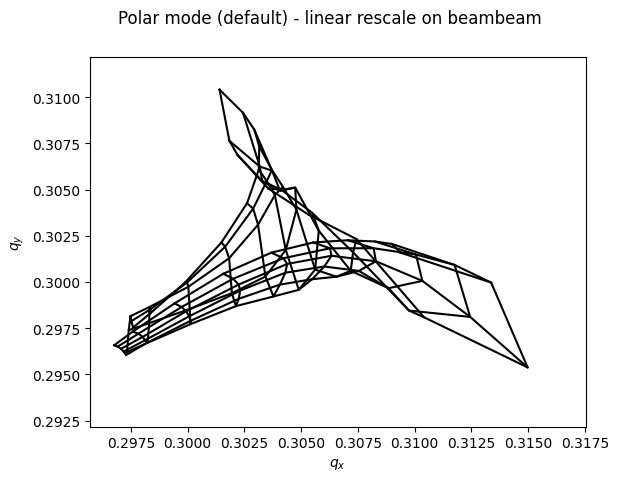

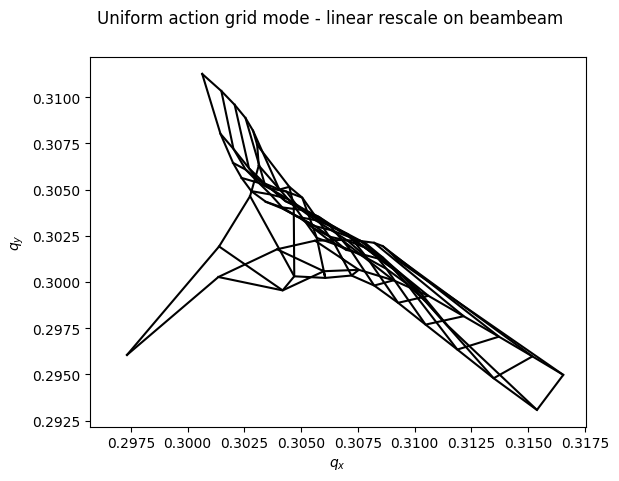

In [44]:
# Compute and plot footprint
fp0 = collider["lhcb1"].get_footprint(nemitt_x=2.5e-6, nemitt_y=2.5e-6)

fp_polar = collider["lhcb1"].get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1)],
)


fp_ua = collider["lhcb1"].get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    mode="uniform_action_grid",
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1)],
)


plt.close("all")

fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
fp0.plot(ax=ax1, label="no rescale bb")
plt.suptitle("Polar mode (default) - no rescale on beambeam")

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111, sharex=ax1, sharey=ax1)
fp_polar.plot(ax=ax2, label="rescale bb")
plt.suptitle("Polar mode (default) - linear rescale on beambeam")

fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111, sharex=ax1, sharey=ax1)
fp_ua.plot()
plt.suptitle("Uniform action grid mode - linear rescale on beambeam")

plt.show()
